This is a supervised classification example taken from the KDD 2009 cup.  A copy of the data and details can be found here: [https://github.com/WinVector/PDSwR2/tree/master/KDD2009](https://github.com/WinVector/PDSwR2/tree/master/KDD2009).  The problem was to predict account cancellation ("churn") from very messy data (column names not given, numeric and categorical variables, many missing values, some categorical variables with a large number of possible levels).  In this example we show how to quickly use `vtreat` to prepare the data for modeling.  `vtreat` takes in `Pandas` `DataFrame`s and returns both a treatment plan and a clean `Pandas` `DataFrame` ready for modeling.


Load our packages/modules.

In [1]:
import os
import pandas
import xgboost
import vtreat
import vtreat.cross_plan
import numpy.random
import wvpy.util
import scipy.sparse
import vtreat.vtreat_db_adapter
import vtreat.stats_utils


In [2]:
vtreat.__version__

'1.2.3'

Read in explanatory variables.

In [3]:
# data from https://github.com/WinVector/PDSwR2/tree/master/KDD2009
# data_dir = "../../pkg/tests/KDD2009/"  # TODO: put back
data_dir = '/Users/johnmount/Documents/work/pyvtreat/pkg/tests/KDD2009'  # TODO: remove
d = pandas.read_csv(
    os.path.join(data_dir, 'orange_small_train.data.gz'),
    sep='\t',
    header=0)
orig_vars = list(d.columns)
d.shape

(50000, 230)

Read in dependent variable we are trying to predict.

In [4]:
churn = pandas.read_csv(
    os.path.join(data_dir, 'orange_small_train_churn.labels.txt'),
    header=None)
churn.columns = ["churn"]
churn['churn'] = churn['churn'] == 1  # replace with True / False
churn.shape

(50000, 1)

In [5]:
churn["churn"].value_counts()

False    46328
True      3672
Name: churn, dtype: int64

Arrange test/train split.

In [6]:
numpy.random.seed(2020)
n = d.shape[0]
# https://github.com/WinVector/pyvtreat/blob/master/Examples/CustomizedCrossPlan/CustomizedCrossPlan.md
split1 = vtreat.cross_plan.KWayCrossPlanYStratified().split_plan(n_rows=n, k_folds=10, y=churn.iloc[:, 0])
train_idx = set(split1[0]['train'])
is_train = [i in train_idx for i in range(n)]
is_test = numpy.logical_not(is_train)

(The reported performance runs of this example were sensitive to the prevalance of the churn variable in the test set, we are cutting down on this source of evaluation variance by using the stratified split.)

In [7]:
d['orig_index'] = range(d.shape[0])
d_train = d.loc[is_train, :].reset_index(drop=True, inplace=False)
churn_train = numpy.asarray(churn.loc[is_train, :]["churn"])
d_test = d.loc[is_test, :].reset_index(drop=True, inplace=False)
churn_test = numpy.asarray(churn.loc[is_test, :]["churn"])

Take a look at the dependent variables.  They are a mess, many missing values.  Categorical variables that can not be directly used without some re-encoding.

In [8]:
d_train.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,orig_index
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,...,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN,0
1,NaN,NaN,NaN,NaN,NaN,525.0,0.0,NaN,NaN,NaN,...,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN,1
2,NaN,NaN,NaN,NaN,NaN,5236.0,7.0,NaN,NaN,NaN,...,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN,2
3,NaN,NaN,NaN,NaN,NaN,1029.0,7.0,NaN,NaN,NaN,...,1J2cvxe,LM8l689qOp,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,NaN,4
4,NaN,NaN,NaN,NaN,NaN,658.0,7.0,NaN,NaN,NaN,...,QqVuch3,LM8l689qOp,NaN,NaN,Qcbd,02N6s8f,Zy3gnGM,am7c,NaN,5


In [9]:
d_train.shape

(45000, 231)

Try building a model directly off this data (this will fail, though some systems such as xgboost can manage the categorical variables if options are set).

In [10]:
fitter = xgboost.XGBClassifier(n_estimators=10, max_depth=3, objective='binary:logistic')
try:
    fitter.fit(d_train, churn_train)
except Exception as ex:
    print(ex)

DataFrame.dtypes for data must be int, float, bool or categorical.  When
                categorical type is supplied, DMatrix parameter
                `enable_categorical` must be set to `True`.Var191, Var192, Var193, Var194, Var195, Var196, Var197, Var198, Var199, Var200, Var201, Var202, Var203, Var204, Var205, Var206, Var207, Var208, Var210, Var211, Var212, Var213, Var214, Var215, Var216, Var217, Var218, Var219, Var220, Var221, Var222, Var223, Var224, Var225, Var226, Var227, Var228, Var229


/Users/johnmount/opt/anaconda3/envs/ai_academy_3_9/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Let's quickly prepare a data frame with none of these issues.

We start by building our treatment plan, this has the `sklearn.pipeline.Pipeline` interfaces.

In [11]:
plan = vtreat.BinomialOutcomeTreatment(
    outcome_target=True,
    outcome_name='churn',
    cols_to_copy=['orig_index'],
    params=vtreat.vtreat_parameters({
        'filter_to_recommended': False,
        'sparse_indicators': True,
    }))

Use `.fit_transform()` to get a special copy of the treated training data that has cross-validated mitigations against nested model bias. We call this a "cross frame." `.fit_transform()` is deliberately a different `DataFrame` than what would be returned by `.fit().transform()` (the `.fit().transform()` would damage the modeling effort due nested model bias, the `.fit_transform()` "cross frame" uses cross-validation techniques similar to "stacking" to mitigate these issues).

In [12]:
cross_frame = plan.fit_transform(d_train, churn_train)

Take a look at the new data.  This frame is guaranteed to be all numeric with no missing values, with the rows in the same order as the training data.

In [13]:
cross_frame.head()

,orig_index,Var61_is_bad,Var36_is_bad,Var64_is_bad,Var168_is_bad,Var27_is_bad,Var96_is_bad,Var109_is_bad,Var98_is_bad,Var149_is_bad,...,Var208_lev_sBgB,Var228_logit_code,Var228_prevalence_code,Var228_lev_F2FyR07IdsN7I,Var228_lev_55YFVY9,Var228_lev_ib5G6X1eUxUn6,Var228_lev_R4y5gQQWY8OodqDV,Var228_lev_xwM2aC7IdeMC0,Var228_lev_TCU50_Yjmm6GIBZ0lL_,Var228_lev_iyHGyLCEkQ
0,0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.145563,0.654178,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.150727,0.654178,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,-0.591072,0.053667,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.150727,0.654178,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,-0.323715,0.018556,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
cross_frame.shape

(45000, 579)

Pick a recommended subset of the new derived variables using the xicor metric.

In [15]:
to_test = list(set(plan.score_frame_['variable']))
to_test.sort()
xicor_scores = vtreat.stats_utils.xicor_for_frame(
    cross_frame.loc[:, to_test],
    numpy.asarray(churn_train, dtype=float),
    n_reps=5)

In [16]:
interesting = xicor_scores['xicor'] > numpy.maximum(xicor_scores['xicor_perm_stddev'], xicor_scores['xicor_se'])
model_vars = list(xicor_scores.loc[interesting, 'variable'])

Fit the model.


In [17]:
# used to fail due to sparse columns
# can also work around this by setting the vtreat parameter 'sparse_indicators' to False
try:
    cross_sparse = xgboost.DMatrix(data=cross_frame.loc[:, model_vars], label=churn_train)
except Exception as ex:
    print(ex)


In [18]:
# works
cross_sparse = scipy.sparse.hstack([scipy.sparse.csc_matrix(cross_frame[[vi]]) for vi in model_vars])

In [19]:
# https://xgboost.readthedocs.io/en/latest/python/python_intro.html
fd = xgboost.DMatrix(
    data=cross_sparse, 
    label=churn_train)

In [20]:
x_parameters = {"max_depth":3, "objective":'binary:logistic', "eval_metric": 'logloss'}
cv = xgboost.cv(x_parameters, fd, num_boost_round=100, verbose_eval=False)

In [21]:
cv.head()

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.504861,0.000561,0.505209,0.000446
1,0.403325,0.000956,0.403935,0.000831
2,0.342645,0.001176,0.343526,0.001105
3,0.304893,0.001281,0.306182,0.001365
4,0.280832,0.001148,0.282346,0.001966


In [22]:
best = cv.loc[cv["test-logloss-mean"]<= min(cv["test-logloss-mean"] + 1.0e-9), :]
best



,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
28,0.222515,0.001378,0.234557,0.003505


In [23]:
ntree = best.index.values[0]
ntree

28

In [24]:
fitter = xgboost.XGBClassifier(n_estimators=ntree, max_depth=3, objective='binary:logistic')
fitter

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=3,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=28, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

In [25]:
model = fitter.fit(cross_sparse, churn_train)

/Users/johnmount/opt/anaconda3/envs/ai_academy_3_9/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:06:37] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Apply the data transform to our held-out data.

In [26]:
test_processed = plan.transform(d_test)

Plot the quality of the model on training data (a biased measure of performance).

<Figure size 432x288 with 0 Axes>

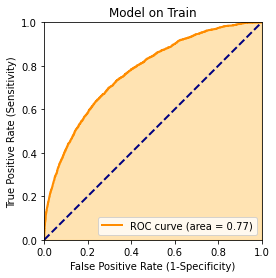

0.7730728687099806

In [27]:
pf_train = pandas.DataFrame({"churn":churn_train})
pf_train["pred"] = model.predict_proba(cross_sparse)[:, 1]
wvpy.util.plot_roc(pf_train["pred"], pf_train["churn"], title="Model on Train")

Plot the quality of the model score on the held-out data.  This AUC is not great, but in the ballpark of the original contest winners.

<Figure size 432x288 with 0 Axes>

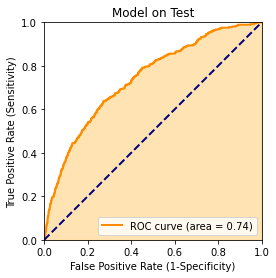

0.7385452930322868

In [28]:
test_sparse = scipy.sparse.hstack([scipy.sparse.csc_matrix(test_processed[[vi]]) for vi in model_vars])
pf = pandas.DataFrame({"churn":churn_test})
pf["pred"] = model.predict_proba(test_sparse)[:, 1]
wvpy.util.plot_roc(pf["pred"], pf["churn"], title="Model on Test")

Notice we dealt with many problem columns at once, and in a statistically sound manner. More on the `vtreat` package for Python can be found here: [https://github.com/WinVector/pyvtreat](https://github.com/WinVector/pyvtreat).  Details on the `R` version can be found here: [https://github.com/WinVector/vtreat](https://github.com/WinVector/vtreat).

We can compare this to the [R solution (link)](https://github.com/WinVector/PDSwR2/blob/master/KDD2009/KDD2009vtreat.md).
